In [1]:
# Dependencies
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from dateutil.parser import parse

https://open.fda.gov/apis/food/enforcement/



In [2]:
# Performing a GET Request and saving the 
# API's response within a variable

with open('food.json') as json_file:
    data = json.load(json_file)


#Importing to dataframe

TotalRecall = pd.DataFrame(data['results'])

group = TotalRecall.groupby(['state'])

count = group.count()

Analysis Goals:

1.  Calculate Recall Durations and compare to notification method, and year

2.  **Ambitious** Find keywords in product description as another grouping method

3.  Group by states and see track recall frequency changes over time


In [3]:
# Calculate Recall Duration
start = pd.to_datetime(TotalRecall['recall_initiation_date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
end = pd.to_datetime(TotalRecall['termination_date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
TotalRecall['Recall Duration'] = (end - start)
TotalRecall['Recall Duration'] = TotalRecall['Recall Duration'].astype(np.int64) / 86400000000000


In [4]:
# Cleaning & Renaming Data
clean_df = TotalRecall[['classification',
                        'initial_firm_notification',
                        'recall_initiation_date',
                        'report_date',
                        'termination_date',
                        'status',
                        'Recall Duration']]
# Rename Titles
clean_df = clean_df.rename(columns = {'classification':'Class',
                                      'initial_firm_notification':'Notification Method',
                                      'recall_initiation_date':'Recall Date',
                                      'report_date':'Report Date',
                                      'termination_date':'Termination Date',
                                      'status':'Status'})

clean_df['Notification Method'] = clean_df['Notification Method'].replace(np.NaN, 'Is Null value')
clean_df.head()

,Class,Notification Method,Recall Date,Report Date,Termination Date,Status,Recall Duration
0,Class II,E-Mail,20120921,20121003,20120926,Terminated,5.0
1,Class I,Press Release,20120831,20121003,20121025,Terminated,55.0
2,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
3,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
4,Class II,Telephone,20120417,20121003,20130716,Terminated,455.0


In [5]:
#clean_df = clean_df.dropna(subset=['Termination Date','Recall Duration','Notification Method'])

#Removes any null value rows
clean_df = clean_df.dropna(how='any',axis=0) 

#Filter out any values that's greater than 5000
clean_df = clean_df[clean_df['Recall Duration'] < 5000]

#Assign each methods (not yet been use in any functions)
Letter = clean_df[clean_df["Notification Method"] == "Letter"]["Recall Duration"]
Email = clean_df[clean_df["Notification Method"] == "E-Mail"]["Recall Duration"]
Press = clean_df[clean_df["Notification Method"] == "Press Release"]["Recall Duration"]
Phone = clean_df[clean_df["Notification Method"] == "Telephone"]["Recall Duration"]
Visit = clean_df[clean_df["Notification Method"] == "Visit"]["Recall Duration"]
Other = clean_df[clean_df["Notification Method"] == "Other"]["Recall Duration"]
Fax = clean_df[clean_df["Notification Method"] == "FAX"]["Recall Duration"]

#Renaming the long string values
clean_df.loc[clean_df['Notification Method'] == "Two or more of the following: Email, Fax, Letter, Press Release, Telephone, Visit", ['Notification Method']] = 'Two or more Method'
clean_df

,Class,Notification Method,Recall Date,Report Date,Termination Date,Status,Recall Duration
0,Class II,E-Mail,20120921,20121003,20120926,Terminated,5.0
1,Class I,Press Release,20120831,20121003,20121025,Terminated,55.0
2,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
3,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
4,Class II,Telephone,20120417,20121003,20130716,Terminated,455.0
...,...,...,...,...,...,...,...
18907,Class I,Letter,20130606,20130731,20140115,Terminated,223.0
18908,Class I,Letter,20130606,20130731,20140115,Terminated,223.0
18911,Class II,Telephone,20151205,20160210,20170321,Terminated,472.0
18912,Class I,Two or more Method,20151028,20160210,20170330,Terminated,519.0


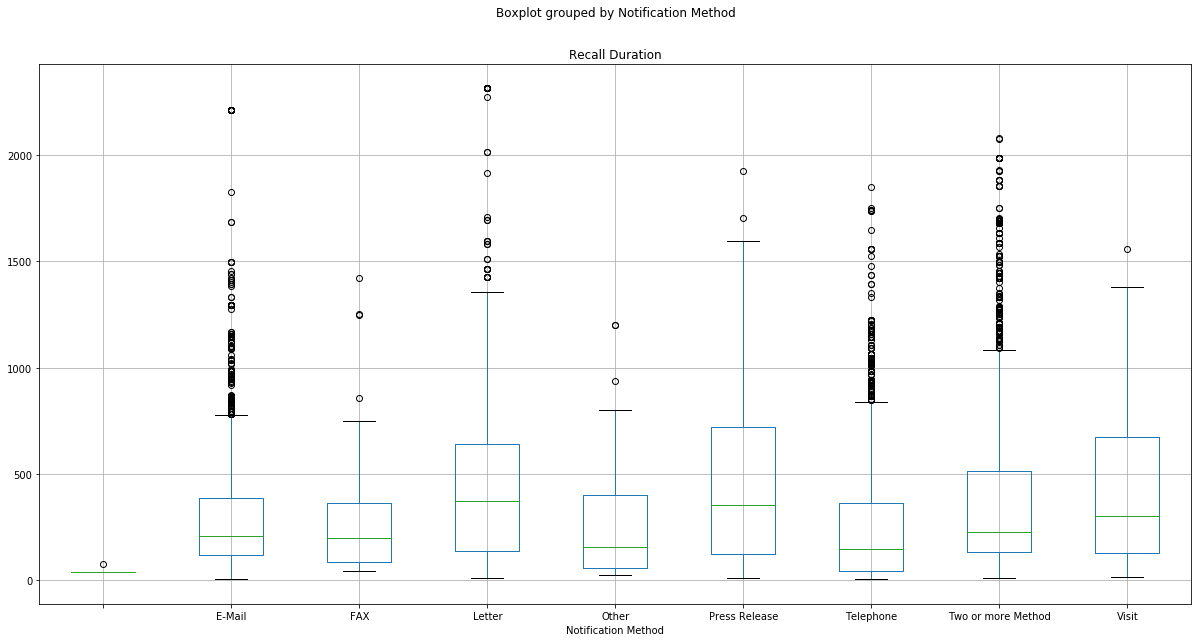

In [6]:
bxplt_method = clean_df.boxplot("Recall Duration", by = "Notification Method", figsize = (20,10))

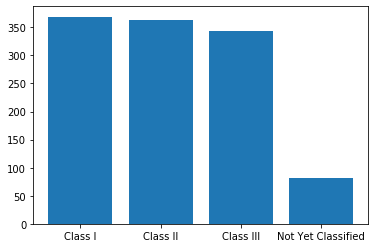

In [7]:
mean = clean_df.groupby('Class')['Recall Duration'].mean().reset_index()
mean = round(mean)
barplt_class = plt.bar(mean['Class'],mean['Recall Duration'], align="center")
plt.show()

In [8]:
#Shuo's working on progress
class1_df = clean_df.loc[clean_df["Class"]== "Class I"]
class2_df = clean_df.loc[clean_df["Class"]== "Class II"]
class3_df = clean_df.loc[clean_df["Class"]== "Class III"]
class1_df = class1_df.groupby("Notification Method")["Class"].count()
class2_df = class2_df.groupby("Notification Method")["Class"].count()
class3_df = class3_df.groupby("Notification Method")["Class"].count()
print(class1_df)


Notification Method
E-Mail                 808
FAX                     40
Letter                 858
Other                   74
Press Release         1508
Telephone              862
Two or more Method    3306
Visit                   40
Name: Class, dtype: int64


In [31]:
initiate = pd.to_datetime(clean_df['Recall Date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
terminate = pd.to_datetime(clean_df['Termination Date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
typenotif = clean_df['Notification Method']

StartFin_df = pd.DataFrame()
StartFin_df["Start"] = initiate
StartFin_df["Finish"] = terminate
StartFin_df["Note"] = typenotif



DateCounts = pd.DataFrame()
DateCounts["Date"] = np.arange(initiate.min(), terminate.max(), dtype='datetime64[D]')
DateCounts["Total"] = ''
DateCounts["E-Mail"] = ''
DateCounts["FAX"] = ''
DateCounts["Letter"] = ''
DateCounts["Other"] = ''
DateCounts["Press Release"] = ''
DateCounts["Telephone"] = ''
DateCounts["Multiple"] = ''
DateCounts["Visit"] = ''


for index, row in DateCounts.iterrows():
    DateCounts["Total"][index] = StartFin_df.Start[(DateCounts["Date"][index] >= StartFin_df["Start"]) & 
                                                    (DateCounts["Date"][index] <= StartFin_df["Finish"])
                                                   ].count()
    DateCounts["E-Mail"][index] = StartFin_df.Start[(DateCounts["Date"][index] >= StartFin_df["Start"]) & 
                                                    (DateCounts["Date"][index] <= StartFin_df["Finish"]) &
                                                    (StartFin_df["Note"] == "E-Mail")
                                                   ].count()
    DateCounts["FAX"][index] = StartFin_df.Start[(DateCounts["Date"][index] >= StartFin_df["Start"]) & 
                                                    (DateCounts["Date"][index] <= StartFin_df["Finish"]) &
                                                    (StartFin_df["Note"] == "FAX")
                                                   ].count()
    DateCounts["Letter"][index] = StartFin_df.Start[(DateCounts["Date"][index] >= StartFin_df["Start"]) & 
                                                    (DateCounts["Date"][index] <= StartFin_df["Finish"]) &
                                                    (StartFin_df["Note"] == "Letter")
                                                   ].count()
    DateCounts["Other"][index] = StartFin_df.Start[(DateCounts["Date"][index] >= StartFin_df["Start"]) & 
                                                    (DateCounts["Date"][index] <= StartFin_df["Finish"]) &
                                                    (StartFin_df["Note"] == "Other Notification Method")
                                                   ].count()
    DateCounts["Press Release"][index] = StartFin_df.Start[(DateCounts["Date"][index] >= StartFin_df["Start"]) & 
                                                    (DateCounts["Date"][index] <= StartFin_df["Finish"]) &
                                                    (StartFin_df["Note"] == "Press Release")
                                                   ].count()
    DateCounts["Telephone"][index] = StartFin_df.Start[(DateCounts["Date"][index] >= StartFin_df["Start"]) & 
                                                    (DateCounts["Date"][index] <= StartFin_df["Finish"]) &
                                                    (StartFin_df["Note"] == "Telephone")
                                                   ].count()
    DateCounts["Multiple"][index] = StartFin_df.Start[(DateCounts["Date"][index] >= StartFin_df["Start"]) & 
                                                    (DateCounts["Date"][index] <= StartFin_df["Finish"]) &
                                                    (StartFin_df["Note"] == "Two or more Method")
                                                   ].count()
    DateCounts["Visit"][index] = StartFin_df.Start[(DateCounts["Date"][index] >= StartFin_df["Start"]) & 
                                                    (DateCounts["Date"][index] <= StartFin_df["Finish"]) &
                                                    (StartFin_df["Note"] == "Visit")
                                                   ].count()
DateCounts

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value i

,Date,Total,E-Mail,FAX,Letter,Other,Press Release,Telephone,Multiple,Visit
0,2008-02-22,1,0,0,0,0,0,0,1,0
1,2008-02-23,1,0,0,0,0,0,0,1,0
2,2008-02-24,1,0,0,0,0,0,0,1,0
3,2008-02-25,1,0,0,0,0,0,0,1,0
4,2008-02-26,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
4293,2019-11-24,5,0,0,0,0,1,1,3,0
4294,2019-11-25,5,0,0,0,0,1,1,3,0
4295,2019-11-26,4,0,0,0,0,1,0,3,0
4296,2019-11-27,4,0,0,0,0,1,0,3,0


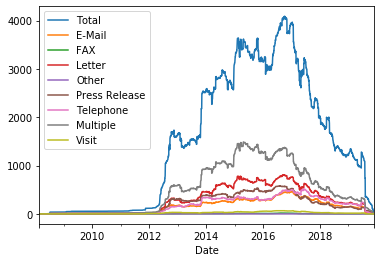

In [32]:
DateCounts.plot(x = "Date")
